In [1]:
import pandas as pd
import pydicom
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D

# Load the CSV file
df = pd.read_csv('RSNA_breast_cancer_data.csv')  # Adjust the path as needed

# Function to load DICOM images and resize them
def load_dicom_image(image_path, target_size=(256, 256)):
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / np.max(image_resized)  # Normalize pixel values
    return np.expand_dims(image_normalized, axis=-1)  # Add a channel dimension

# Load all the images and labels
image_paths = df['image_path'].values
labels = df['cancer'].values

# Prepare data
images = []
for path in image_paths:
    image = load_dicom_image(path)  # Directly use the full path from the CSV
    images.append(image)

images = np.array(images)
labels = np.array(labels)

In [3]:
print(images.shape)

(2374, 256, 256, 1)


In [4]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of the remaining data

# # Expand dimensions to fit the model input (Batch, Height, Width, Channels)
# X_train = np.expand_dims(X_train, axis=-1)
# X_val = np.expand_dims(X_val, axis=-1)
# X_test = np.expand_dims(X_test, axis=-1)

# Use ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator()

# Flow the data using ImageDataGenerator
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [5]:
# Build the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model
base_model.trainable = False

# Build the complete model
model = Sequential([
    tf.keras.layers.Conv2D(3, (1, 1), padding='same', input_shape=(256, 256, 1)),  # Adjust grayscale input to 3 channels
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 3)    │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,645,511 (94.02 MB)

 Trainable params: 1,053,703 (4.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [6]:
# Train the model using fit with ImageDataGenerator
history = model.fit(train_generator, 
                    epochs=15, 
                    validation_data=val_generator)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.5560 - loss: 0.6767 - val_accuracy: 0.5190 - val_loss: 0.7530
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.6191 - loss: 0.6383 - val_accuracy: 0.5190 - val_loss: 1.0544
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.6349 - loss: 0.6181 - val_accuracy: 0.5190 - val_loss: 0.7938
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.6406 - loss: 0.6142 - val_accuracy: 0.5190 - val_loss: 0.7249
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.6373 - loss: 0.6068 - val_accuracy: 0.5190 - val_loss: 0.6851
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.6270 - loss: 0.6022 - val_accuracy: 0.6203 - val_loss: 0.6679
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.6380 - loss: 0.6142 - val_accuracy: 0.5949 - val_loss: 0.6692
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.6257 - loss: 0.6125 - val_accuracy: 0.5527 - v

In [7]:
# Evaluate on test data after training is complete
test_generator = val_datagen.flow(X_test, y_test, batch_size=32)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"\nTest accuracy: {test_acc}")

8/8 - 11s - 1s/step - accuracy: 0.6807 - loss: 0.6001

Test accuracy: 0.680672287940979


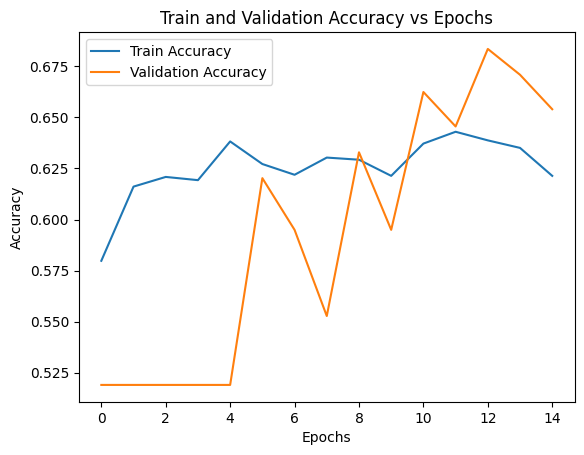

In [8]:
# Plotting the training and validation accuracy after all epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy vs Epochs')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


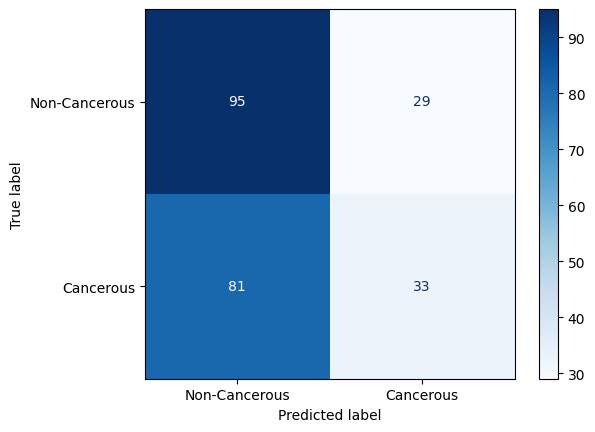

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the test set
y_pred_probs = model.predict(test_generator)

# Convert probabilities to binary class labels
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.show()